<a href="https://colab.research.google.com/github/hey0wing/Machine-Translation-models-for-Cantonese-English-pair/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

FYP: Machine translation models for Cantonese­English pair

In [ ]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install matplotlib==3.2.2
!pip install --upgrade pycantonese

     |████████████████████████████████| 3.7MB 13.7MB/s 
     |████████████████████████████████| 2.8MB 21.4MB/s 
     |████████████████████████████████| 71kB 12.7MB/s 


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import pycantonese as pc
from pycantonese.word_segmentation import Segmenter

## Setup input pipeline

In [ ]:
# from google.colab import files
# files.upload()
 
import pandas as pd
import glob
import os

all_txt = glob.glob(os.getcwd() + "/*.txt")
if len(all_txt) > 0:
  corpus = []
  for txt in all_txt:
    f = open(txt, 'r')
    corpus.extend([x for x in f.read().strip().splitlines() if x])
    f.close()
  corpus_yue = corpus[::2]
  corpus_eng = corpus[1::2]
  df_txt = pd.DataFrame({'zh': corpus_yue, 'en': corpus_eng})
  df_txt.to_csv('Netflix.csv', sep='\t', encoding='utf-8')

In [ ]:
all_csv = glob.glob(os.getcwd() + "/*.csv")  
 
df_from_each_file = (pd.read_csv(f,sep='\t',encoding='utf-8', index_col=0) for f in all_csv)
df = pd.concat(df_from_each_file, ignore_index=True)

Preprocess Cantonese sentences

In [ ]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.rename(columns={'zh': 'yue', 'en': 'eng'})

# Unify the character to traditional
!wget -qnc https://raw.githubusercontent.com/skydark/nstools/master/zhtools/zh_wiki.py https://raw.githubusercontent.com/skydark/nstools/master/zhtools/langconv.py
from langconv import *
for file in glob.glob(os.getcwd() + "/*.py"):
  os.remove(file)
def ConvTrad(x):
  # !pip install opencc
  # import opencc
  # converter = opencc.OpenCC('s2hk.json')
  return Converter('zh-hant').convert(x)
 
# segment Cantonese sentences
segmenter = Segmenter(
    allow = {'甘乃迪', '坦帕', '塞拉里昂', '唔淨至', '宗教', '儀式', '上漲', '功夫', '卑牌', "系咪", '就系', '我地', '你地', '佢地', '距地', '呢到', '帶嚟'},
    disallow = {'系呢', '係呢', "喺呢", '呢個係'}
)
def CantoSeg(x):
  return ' '.join(pc.segment(x, cls=segmenter))
 
# replace unuified words to HK version and unify variants into single form
def haai5haai2Conv(x):
  if all(h in x.split(' ') for h in ['系', '係']):
    x = ' '.join(['喺' if len(x) == 1 and x == '係' else x for x in x.split(' ')])
    x = ' '.join(['係' if len(x) == 1 and x == '系' else x for x in x.split(' ')])
  return x

singleReplaceSeq = {
    "系": "係", 
    "里": "裏", 
    '距': '佢',
    '黎': '呢', 
    '果': '嗰', 
    'D': '啲',
    '卑': '俾'
}
def singleReplace(x):
  return ' '.join([singleReplaceSeq[x] if len(x) == 1 and x in singleReplaceSeq.keys() else x for x in x.split(' ')])

combo = [f + ' ' + s 
         for f in ['呢', '嗰', '一'] 
         for s in ['陣', '啲', '個', '輯', '份', '間']]
def combineSequence(x):
  for c in combo:
    if c in x:
      x = x.replace(c, c[::2])
  return x

df['yue'] = df['yue'].apply(lambda x: ConvTrad(x))
df['yue'] = df['yue'].apply(lambda x: CantoSeg(x))
df['yue'] = df['yue'].apply(lambda x: haai5haai2Conv(x))
df['yue'] = df['yue'].apply(lambda x: singleReplace(x))
df['yue'] = df['yue'].apply(lambda x: combineSequence(x))

df['yue'] = df['yue'].replace(
  {
    '噶': '嘅',
    '裡': '裏',
    '哩': '呢',
    '咯': '囉',
    '佐': '咗',
    '姖': '佢',
    '系咪': '係咪',
    '就系': '就係',
    '即系': '即係',
    '我地': '我哋',
    '你地': '你哋',
    '距地': '佢哋',
    '呢到': '呢度',
    '卑牌': '啤牌',
    '唔淨至': '唔淨止'
  }, regex=True)


In [ ]:
# Remove all punctuation and extra space
for column in df:
  df[column] = df[column].str.replace(r'[^\w\s]+', ' ')
  df[column] = df[column].str.replace(r' +', ' ')
  df[column] = df[column].str.strip()
 
# Let the tokenizer perform segment for Cantonese
df['yue'] = df['yue'].apply(lambda x: x.replace(' ', ''))

df.head()

# from pprint import *
# corpus = pc.hkcancor()
# pprint(corpus.search(character='難用'))
# df[df['yue'].str.contains(' ')]

,yue,eng
0,大家好我叫Frank,Hi my name is Frank
1,我收集人哋嘅秘密,and I collect secrets
2,而一切都源於我,It all started with a crazy idea
3,2004年11月一個瘋狂嘅諗法,in November of 2004
4,我當時打印咗三千張,I printed up 3 000 self addressed postcards


### Set translational direction

In [ ]:
inp_lang = 'eng'
tar_lang = 'yue'
inp = df[inp_lang]
tar = df[tar_lang]
dataset = tf.data.Dataset.from_tensor_slices((inp.values, tar.values))

## Split dataset into train, test and validation

In [ ]:
DATASET_SIZE = len(list(dataset))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.05 * DATASET_SIZE)

dataset = dataset.shuffle(500)
train_examples = dataset.take(train_size)
remaining = dataset.skip(train_size)
test_examples = remaining.take(test_size)
val_examples = remaining.skip(test_size)

print('Train size:', len(list(train_examples)))
print('Test size:', len(list(test_examples)))
print('Validation size:', len(list(val_examples)))
print()
print('Total size:', DATASET_SIZE)

Train size: 8830
Test size: 490
Validation size: 492

Total size: 9812


In [ ]:
for inp, tar in train_examples.take(3):
  print(inp)
  print(tar)
  print('-' * 10)

tf.Tensor(b'They had a big patient population', shape=(), dtype=string)
tf.Tensor(b'\xe4\xbd\xa2\xe5\x93\x8b\xe7\x95\xb6\xe6\x99\x82\xe6\x9c\x89\xe5\xa5\xbd\xe5\xa4\x9a\xe7\x97\x85\xe4\xba\xba', shape=(), dtype=string)
----------
tf.Tensor(b'that kind of help fill in this feedback loop', shape=(), dtype=string)
tf.Tensor(b'\xe5\x8e\xbb\xe5\xa1\xab\xe8\xa3\x9c\xe5\x91\xa2\xe5\x80\x8b\xe5\x8f\x8d\xe9\xa5\x8b\xe5\xbe\xaa\xe7\x92\xb0\xe5\xad\x98\xe5\x9c\xa8\xe5\x98\x85\xe7\xa9\xba\xe9\x9a\x99', shape=(), dtype=string)
----------
tf.Tensor(b'for behavior change', shape=(), dtype=string)
tf.Tensor(b'\xe7\x94\xa8\xe4\xbd\x9c\xe8\xa1\x8c\xe7\x82\xba\xe6\x94\xb9\xe8\xae\x8a\xe5\x98\x85\xe7\x90\x86\xe5\xbf\xb5', shape=(), dtype=string)
----------


In [ ]:
sample_examples = []
num_samples = 5

for inp_t, tar_t in train_examples.take(num_samples):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
  
  print(inp)
  print(tar)
  print('-' * 10)
  
  sample_examples.append((inp, tar))

What does this mean Help me understand what the data is
呢份報告說明乜嘢請幫我理解呢啲數據代表乜嘢
----------
so it s an easy story to tell
所以亦好容易說明
----------
Now they measured one other variable
跟住佢哋測試咗另一個變量
----------
He said For three years my girlfriend and I
佢話三年嚟女朋友同我
----------
They would get dentures and if you got dentures
雖然都可以戴假牙但是戴假牙
----------


Create a custom subwords tokenizer from the training dataset. 

In [ ]:
if inp_lang == 'yue':
  input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
  target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13)
else:
  input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13)
  target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)

Check the tokenizers with sample string

In [ ]:
# We can use string in dataset
sample_inp = sample_examples[0][0]
sample_tar = sample_examples[0][1]

tokenized_inp = input_tokenizer.encode(sample_inp)
print ('Tokenized string is {}'.format(tokenized_inp))

original_inp = input_tokenizer.decode(tokenized_inp)
print ('The original string: {}'.format(original_inp))

tokenized_tar = target_tokenizer.encode(sample_tar)
print ('Tokenized string is {}'.format(tokenized_tar))

original_tar = target_tokenizer.decode(tokenized_tar)
print ('The original string: {}'.format(original_tar))

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [ ]:
for ts in tokenized_inp:
  print ('{} ----> {}'.format(ts, input_tokenizer.decode([ts])))
print()
for ts in tokenized_tar:
  print ('{} ----> {}'.format(ts, target_tokenizer.decode([ts])))

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [ ]:
def encode(lang1, lang2):
  lang1 = [input_tokenizer.vocab_size] + input_tokenizer.encode(
      lang1.numpy()) + [input_tokenizer.vocab_size+1]

  lang2 = [target_tokenizer.vocab_size] + target_tokenizer.encode(
      lang2.numpy()) + [target_tokenizer.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [ ]:
def tf_encode(inp, tar):
  result_inp, result_tar = tf.py_function(encode, [inp, tar], [tf.int64, tf.int64])
  result_inp.set_shape([None])
  result_tar.set_shape([None])

  return result_inp, result_tar

Note: To keep this example small and relatively fast, drop examples with a length of over 100 tokens.

In [ ]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
num_examples = 0
for inp_indices, tar_indices in train_dataset:
  num_examples += 1
print(f"Total size: {num_examples}")

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

Total size: 8353


In [ ]:
# Check with train set
inp_indices, tar_indices  = next(iter(train_dataset))
print(inp_indices)
print(tar_indices)

num_examples = 0
for inp_indices, tar_indices in train_dataset:
  # cond1 = len(inp_indices) <= MAX_LENGTH
  # cond2 = len(tar_indices) <= MAX_LENGTH
  # assert cond1 and cond2
  num_examples += 1

print(f"\nAll string are less than {MAX_LENGTH} tokens")
print(f"Total batches: {num_examples}")

tf.Tensor(
[[7538   42   12 ...    0    0    0]
 [7538   23   81 ...    0    0    0]
 [7538  141 6428 ...    0    0    0]
 ...
 [7538   24  190 ...    0    0    0]
 [7538 2459    7 ...    0    0    0]
 [7538 1616  292 ...    0    0    0]], shape=(64, 20), dtype=int64)
tf.Tensor(
[[3132   33   15 ...    0    0    0]
 [3132   19  236 ...    0    0    0]
 [3132   40  250 ...    0    0    0]
 ...
 [3132  307    2 ...    0    0    0]
 [3132  361  668 ...    0    0    0]
 [3132   18    3 ...    0    0    0]], shape=(64, 26), dtype=int64)

All string are less than 40 tokens
Total batches: 131


In [ ]:
# Check with val set
inp_batch, tar_batch = next(iter(val_dataset))
inp_batch, tar_batch

(<tf.Tensor: shape=(64, 37), dtype=int64, numpy=
 array([[7538,   24,  738, ...,    0,    0,    0],
        [7538,    5,  109, ...,    0,    0,    0],
        [7538,  719,  241, ...,    0,    0,    0],
        ...,
        [7538,   58, 4465, ...,    0,    0,    0],
        [7538,   24, 7009, ...,    0,    0,    0],
        [7538,  301,   52, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[3132,   62,    2, ..., 3133,    0,    0],
        [3132,    2,   53, ...,    0,    0,    0],
        [3132,  792,    3, ...,    0,    0,    0],
        ...,
        [3132,  295,   35, ...,    0,    0,    0],
        [3132, 1386,  432, ...,  773, 1559, 3133],
        [3132,   31,  299, ...,    0,    0,    0]])>)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


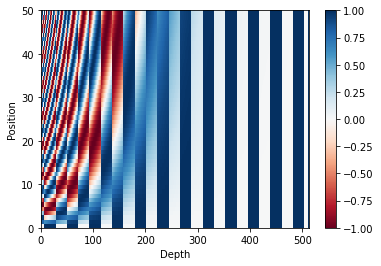

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = input_tokenizer.vocab_size + 2
target_vocab_size = target_tokenizer.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

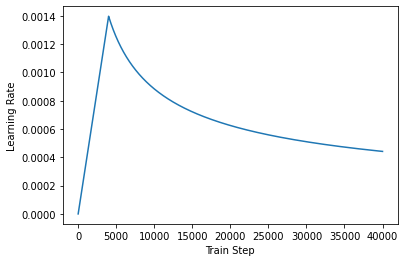

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

Portuguese is used as the input language and English is the target language.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.0596 Accuracy 0.0006
Epoch 1 Batch 50 Loss 7.9781 Accuracy 0.0143
Epoch 1 Batch 100 Loss 7.8619 Accuracy 0.0286
Epoch 1 Loss 7.7914 Accuracy 0.0313
Time taken for 1 epoch: 18.019159078598022 secs

Epoch 2 Batch 0 Loss 7.5093 Accuracy 0.0357
Epoch 2 Batch 50 Loss 7.3443 Accuracy 0.0426
Epoch 2 Batch 100 Loss 7.1739 Accuracy 0.0432
Epoch 2 Loss 7.0715 Accuracy 0.0419
Time taken for 1 epoch: 7.000123739242554 secs

Epoch 3 Batch 0 Loss 6.6718 Accuracy 0.0323
Epoch 3 Batch 50 Loss 6.4684 Accuracy 0.0427
Epoch 3 Batch 100 Loss 6.3424 Accuracy 0.0424
Epoch 3 Loss 6.2873 Accuracy 0.0414
Time taken for 1 epoch: 6.8620076179504395 secs

Epoch 4 Batch 0 Loss 6.1155 Accuracy 0.0379
Epoch 4 Batch 50 Loss 6.0237 Accuracy 0.0508
Epoch 4 Batch 100 Loss 5.9864 Accuracy 0.0531
Epoch 4 Loss 5.9746 Accuracy 0.0524
Time taken for 1 epoch: 6.703415632247925 secs

Epoch 5 Batch 0 Loss 5.9240 Accuracy 0.0625
Epoch 5 Batch 50 Loss 5.8661 Accuracy 0.0625
Epoch 5 Batch 100 Loss 5.8226 Acc

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`input_tokenizer`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == target_tokenizer.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [ ]:
def evaluate(inp_sentence):
  start_token = [input_tokenizer.vocab_size]
  end_token = [input_tokenizer.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + input_tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [target_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == target_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
# Chinese font in matplotlib
!wget -qO taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties

chinese = FontProperties(fname=r'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = input_tokenizer.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    # show Chinese character
    fontdict = {"fontproperties": chinese}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[input_tokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([target_tokenizer.decode([i]) for i in result 
                        if i < target_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

and now you re seeing them pop up
同時我哋起咗30英里 

Input: and now you re seeing them pop up
Predicted translation: 我哋嚟咗大家都係咗


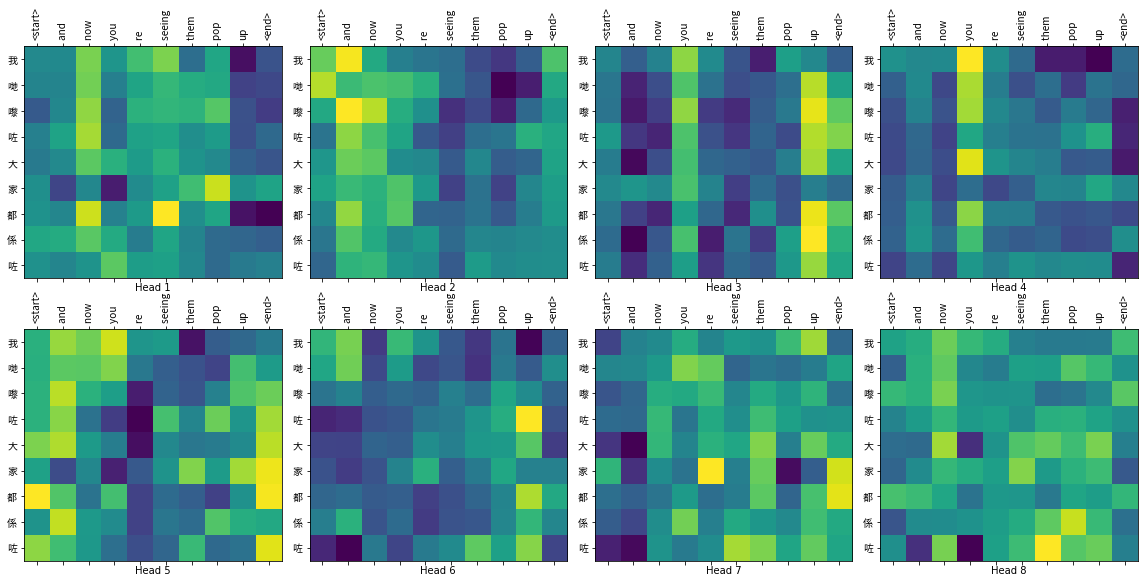

In [ ]:
import random
ran = random.randint(1, len(train_examples))

for inp_t, tar_t in train_examples.take(ran):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
print(inp)
print(tar, '\n')

translate(inp, plot='decoder_layer4_block2')